<a href="https://colab.research.google.com/github/sts-sadr/-Data-Science-A-Z-Real-Life-Data-Science-Exercises-Included-with-DSS/blob/master/Farsi_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 5.7MB/s 
     |████████████████████████████████| 3.8MB 13.8MB/s 
     |████████████████████████████████| 890kB 45.1MB/s 
     |████████████████████████████████| 1.1MB 37.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=393c6e83f89123dff38d1d87ece01fd17ea3e9a6fc7ff3f32f605e9fc4728abd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import csv
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BasicTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

In [0]:
print(tf.__version__)

2.2.0


In [0]:
def load_data(file_name):
    f = open(file_name, 'r')
    data = pd.read_csv(f, delimiter=',', encoding='utf-8')
    return data

file_name = 'taghche.csv'
df = load_data(file_name)
df.head()

,date,comment,bookname,rate,bookID,like
0,1395/11/14,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,0.0,3.0,2.0
1,1395/11/14,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,2.0
2,1394/06/06,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,0.0
3,1393/09/02,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,2.0,3.0,0.0
4,1393/06/29,کتاب خوبی است,سرهنگ کسی ندارد برایش نامه بنویسد,3.0,3.0,0.0


In [0]:
df = df.drop(columns=['date', 'bookname', 'bookID', 'like'])
# df = df.rename(columns={'Text':'text','Suggestion': 'label'})
df.loc[(df.rate < 3), 'label'] = '0'
df.loc[(df.rate >= 3), 'label'] = '1'
df = df.drop(columns=['rate'])
df.head()

,comment,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,کتاب خوبی است,1


In [0]:
df_pos = df.loc[df.label == '1']
df_neg = df.loc[df.label == '0']
len(df_neg)

13868

In [0]:
def create_small_dataset(df_pos, df_neg, n_samples):
    duplicates = set()
    counter = 0
    data = {}
    data['comment'] = []
    data['polarity'] = []
#     fout = open('small_dataset.csv', 'a+', encoding='UTF-8')
    while counter < n_samples:
        index = np.random.randint(0, len(df_pos))
        if index in duplicates:
            continue
        row = df_pos.iloc[index]
        comment = remove_emoji(row['comment'])
        label = row['label']
        data['comment'].append(comment)
        data['polarity'].append(label)
#         data = data.append(row, ignore_index=True)
#         fout.write(row['comment'] + ',' + str(row['label']) + '\n')
#         fout.write('\"' + row['comment'] + '\"' + ',' + str(row['label']) + '\n')
        duplicates.add(index)
        counter += 1
    
    duplicates.clear()
    counter = 0
    while counter < n_samples:
        index = np.random.randint(0, len(df_neg))
        if index in duplicates:
            continue
        row = df_neg.iloc[index]
        comment = remove_emoji(row['comment'])
        label = row['label']
        data['comment'].append(comment)
        data['polarity'].append(label)
#         data = data.append(row, ignore_index=True)
#         fout.write(row['comment'] + ',' + str(row['label']) + '\n')
        duplicates.add(index)
        counter += 1
    return pd.DataFrame.from_dict(data)
#     fout.close()
    
def remove_emoji(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = re.sub(emoji_pattern, ' ', text).replace('.','')
    return re.sub(r'[a-z]+[A-Z]+', '', text, re.I)
    

In [0]:
dataset = create_small_dataset(df_pos, df_neg, 5000)

#shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
# res_df.polarity = res_df.polarity.astype('str')
dataset

,comment,polarity
0,چرا کتابای رایگانتون اینقدر مسخره ان؟,0
1,قیمت کتاب زیاداست,0
2,استاد نعمت االه ریاضی استاد دانشکاه من بودن حق...,1
3,کتاب بسیار خوبی بود با اینکه خلاصه شده بود ولی...,1
4,به قول لیر شاه ، از هیچ ، هیچ زاید,0
...,...,...
9995,همونطور که خیلی از دوستان گفتن فقط نمونه جذاب ...,0
9996,حس سردیِ اینجا اذیت کننده‌س یه‌کم\n\nغم غریبی ...,1
9997,بنظرم بعضی موقع ها از تکراری بودن کلمات خسته م...,0
9998,بنظر من ک اصلا جالب نبود من نسخه چاپیشو خوندم ...,0


In [0]:
train_data, test_data = train_test_split(dataset, test_size=0.2)

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


In [0]:
def convert_data_into_input_example(data):
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid= None,
            text_a= data.iloc[i]['comment'],
            text_b= None,
            label= data.iloc[i]['polarity']
        )
        input_examples.append(example)
    return input_examples

In [0]:
train_input_examples = convert_data_into_input_example(train_data)
val_input_examples = convert_data_into_input_example(test_data)


label_list = ['0', '1']
bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)
bert_val_dataset = glue_convert_examples_to_features(examples=val_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)

for i in range(10):
    print('Example: {}'.format(bert_train_dataset[i]))

Example: InputFeatures(input_ids=[101, 19015, 105579, 10239, 26764, 10388, 791, 34032, 11892, 27088, 23909, 764, 23473, 90224, 10327, 21312, 29869, 13367, 10658, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [0]:
ex = bert_train_dataset[0]
in_ids = ex.input_ids
decoded_seq = tokenizer.decode(in_ids, skip_special_tokens=True)
print(decoded_seq)

کتاب خوبی درباره وقف بود ولی بیشتر بچگانه به نظر میامد


In [0]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# loss = tf.keras.losses.BinaryCrossentropy()
# metric = tf.keras.metrics.BinaryCrossentropy('accuracy')
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

for i in range(3):
    print(bert_train_dataset[i])

InputFeatures(input_ids=[101, 19015, 105579, 10239, 26764, 10388, 791, 34032, 11892, 27088, 23909, 764, 23473, 90224, 10327, 21312, 29869, 13367, 10658, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [0]:
# model.fit(bert_train_dataset, validation_data=bert_val_dataset, epochs=3)

In [0]:
def my_solution(bdset):
    
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return ([input_ids, attention_mask, token_type_ids], label)

In [0]:
x_train, y_train = my_solution(bert_train_dataset)
x_val, y_val = my_solution(bert_val_dataset)

print('x_val size: {}'.format(len(x_val)))
def example_to_features(input_ids, attention_masks, token_type_ids, y):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids},y


train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)

print('format of model input examples: '.format(train_ds.take(1)))

EPOCHS = 5

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


# history = model.fit(x_train, y_train, epochs=5, validation_data=x_val, verbose=1)

x_val size: 3
format of model input examples: 
Epoch 1/5
250/250 [==============================] - 137s 548ms/step - loss: 0.5838 - accuracy: 0.6894 - val_loss: 0.5079 - val_accuracy: 0.7665
Epoch 2/5
250/250 [==============================] - 134s 535ms/step - loss: 0.4867 - accuracy: 0.7747 - val_loss: 0.5002 - val_accuracy: 0.7650
Epoch 3/5
250/250 [==============================] - 134s 534ms/step - loss: 0.4131 - accuracy: 0.8227 - val_loss: 0.5112 - val_accuracy: 0.7685
Epoch 4/5
250/250 [==============================] - 134s 534ms/step - loss: 0.3515 - accuracy: 0.8558 - val_loss: 0.5692 - val_accuracy: 0.7630
Epoch 5/5
250/250 [==============================] - 134s 535ms/step - loss: 0.2901 - accuracy: 0.8871 - val_loss: 0.6147 - val_accuracy: 0.7575


In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

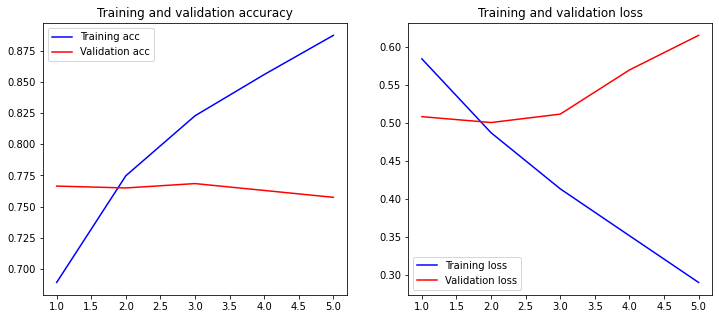

In [0]:
plot_history(history)

In [0]:
# print(len(list(val_ds)))
predictions = model.predict(val_ds)
print(predictions[0].shape)
print()
predictions_classes = np.argmax(predictions[0], axis = 1)
# print('pred class:', predictions_classes)
for i in range(10):
    print('comment: {}\n, actual label: {}, predicted label: {}'.format(test_data.iloc[i]['comment'], val_input_examples[i].label, predictions_classes[i]))

(2000, 2)

comment: کسالت آور بود 
ولی چون یک داستان نسباتا واقعیست ، به خاطر حقایقی که در اون وجود داشت بخوبی ما رو با فرهنگ و اعتقادات مردم اون دوره انگلیس آشنا میکنه
داستان کشتی تایتانیک
, actual label: 0, predicted label: 1
comment: شیوایی کلام میتوانست بهتر باشد
, actual label: 0, predicted label: 0
comment: باسلام،برای قشرخاصی طراحی شده کتاب ودرکش برای عموم کمی سخت وگیج کننده است
, actual label: 0, predicted label: 1
comment: بد نبود- راضی کننده بود
, actual label: 1, predicted label: 0
comment: من به عنوان یه نویسنده این مجله تقاضا میکنم همه ازش حمایت کنند! این یه کار نمونه ای علمی ترویجی نو تو زمینه زبان کوردی هست و نیاز به حمایت همه داره
, actual label: 1, predicted label: 0
comment: دوستشدارمدوستش خواهی داشت✌
, actual label: 1, predicted label: 0
comment: خیلی قشنگ بود  
مرسی طاقچه جون
, actual label: 0, predicted label: 1
comment: همه کتاب داره درباره جزییات ظاهر بقیه و محیط صحبت میکنهچنگی ب دل نمیزنهبسیار خسته کنندس
, actual label: 0, predicted label: 0
comment: کتاب رو خون

In [0]:
MAX_SEQ_LENGTH = 128

def example_to_features_predict(input_ids, attention_masks, token_type_ids):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}


def get_prediction(in_sentences):
  labels = ["0", "1"]
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = '0') for x in in_sentences] # here, "" is just a dummy label
  predict_input_fn = glue_convert_examples_to_features(examples=input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)
  x_test_input, y_test_input = my_workaround(predict_input_fn)
  test_ds   = tf.data.Dataset.from_tensor_slices((x_test_input[0], x_test_input[1], x_test_input[2])).map(example_to_features_predict).batch(32)

  predictions = model.predict(test_ds)
#   print('predictions:', predictions[0].shape)
  predictions_classes = np.argmax(predictions[0], axis = 1)
#   print('pred class:', predictions_classes)
  return [(sentence, prediction) for sentence, prediction in zip(in_sentences, predictions_classes)]

In [0]:
# pred_sentences = ['به نظر کتاب خوبی نمی ومد', ' رایگان بودنش فوق العادش میکند']
pred_sentences = [comment for comment,l in test_data.sample(20).values]
# print(pred_sentences)
predictions = get_prediction(pred_sentences)
for p in predictions:
    print(p)

('واقعا چطور همچین کتابایی اجازه نشر پیدا میکنن؟', 0)
('روش چی ؟', 0)
('بنظرم کتاب زندگینامه شهید رو رایگان کردن صورت خوشی نداره! چون اونی که براش مهمه بخونه پولشو میده میخره کسی هم که سلیقه مطالعه کتابش این مدلی نیست، رایگانم بشه نمیخونه', 0)
('سوالات کجا میاد کجا باید جواب بدیم', 0)
('سمنوپزان ، مسلول و  زن زیادی  خوب بودند ؛ در کل ادم رو به گذشته های دور و شیوه زندگی اونها میبره و از این جهت فوق العاده است\nممنون از طاقچه بابت برنامه خوبش و به خاطر کتابهایی که رایگان کردید', 1)
('کتاب فوق العاده ای بود به خیلی از شبهات در غالب داستان جواب داده  حتما پیشنهاد میکنم', 1)
('چقدر قشنگ بالا و پایین زندگی رو نشون داده بود  ', 0)
('ترجمه اش اصلا خوب نیست', 0)
('واقعا این کتاب عالییییییییییییییییییییییییییییییییییییییییییییییییه یه حرف نگفته اس که غمباد شده تو دلمون واقعا دست مریزاد سرکاره خانوم عالیشاهی با آرزوی بهترین ها و بالاترین درجات برای شما نویسنده محترمه', 1)
('واقعاً قیمت ها رو بر چه اساس تعیین میکنید نمیدونم قیمت نسخه چاپی ۵۰ تومان هست که با توجه به قیمت کاغذ منطقی هست اما نسخه ال

In [0]:
print("Evaluating the BERT model")
model.evaluate(val_ds)

Evaluating the BERT model
32/32 [==============================] - 9s 293ms/step - loss: 0.6147 - accuracy: 0.7575


[0.6146795749664307, 0.7574999928474426]